# Athens Quick Start: From GeoTIFFs to Tmrt Maps

This tutorial walks through a complete SOLWEIG workflow using real data from Athens, Greece.
You'll load a Digital Surface Model, rasterise tree vectors, and compute a Mean Radiant Temperature (Tmrt) map
for a hot July afternoon — all in a few lines of code.

**Data sources:**

- DSM/DEM: Derived from LiDAR data, Hellenic Cadastre ([ktimatologio.gr](https://www.ktimatologio.gr/))
- Tree vectors: Derived from Athens Urban Atlas ([Copernicus](https://land.copernicus.eu/local/urban-atlas)) and [geodata.gov.gr](https://geodata.gov.gr)
- EPW weather: Generated via [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/) using Copernicus Climate Change Service information [2025].
  Neither the European Commission nor ECMWF is responsible for any use that may be made of the Copernicus information or data it contains.


In [1]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import solweig
from pyproj import CRS

# Paths — adjust if running from a different location
DATA_DIR = Path("demos/data/athens")
WORK_DIR = Path("temp/tutorial_cache")
WORK_DIR.mkdir(parents=True, exist_ok=True)

assert (DATA_DIR / "DSM.tif").exists(), f"Demo data not found at {DATA_DIR.resolve()}"

# Study area extents (EPSG:2100 — Greek Grid)
EXTENTS_BBOX = [476800, 4205850, 477200, 4206250]
TARGET_CRS = 2100

INFO:solweig:GPU acceleration enabled by default
[GPU] GPU acceleration enabled


## 1. Inspect the Digital Surface Model

The DSM contains building and terrain heights. Let's load it and see what the study area looks like.


INFO:solweig.io:No-data value is -9999.0, replacing with NaN


DSM shape: (400, 400)
Height range: 109.0 – 174.4 m
CRS: PROJCS["GGRS87 / Greek Grid",GEOGCS["GGRS87",DATUM["Greek_Geodetic_Reference_System_1987",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6121"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4121"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",24],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2100"]]


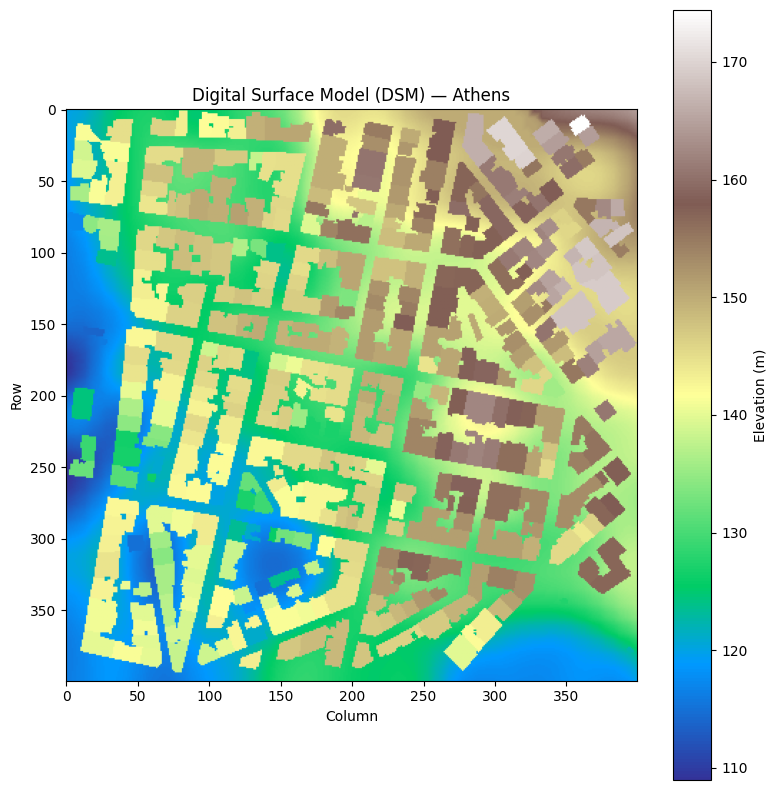

In [2]:
dsm, dsm_transform, dsm_crs, _ = solweig.io.load_raster(str(DATA_DIR / "DSM.tif"))

print(f"DSM shape: {dsm.shape}")
print(f"Height range: {np.nanmin(dsm):.1f} – {np.nanmax(dsm):.1f} m")
print(f"CRS: {dsm_crs}")

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(dsm, cmap="terrain", vmin=np.nanmin(dsm), vmax=np.nanmax(dsm))
ax.set_title("Digital Surface Model (DSM) — Athens")
ax.set_xlabel("Column")
ax.set_ylabel("Row")
plt.colorbar(im, ax=ax, label="Elevation (m)")
plt.tight_layout()
plt.show()

## 2. Rasterise tree vectors into a Canopy DSM

The Athens dataset includes a GeoPackage with tree polygon geometries and heights.
We rasterise these to create a CDSM (Canopy Digital Surface Model) at 1 m resolution.


Tree polygons: 6
Height range: 6.0 – 14.0 m


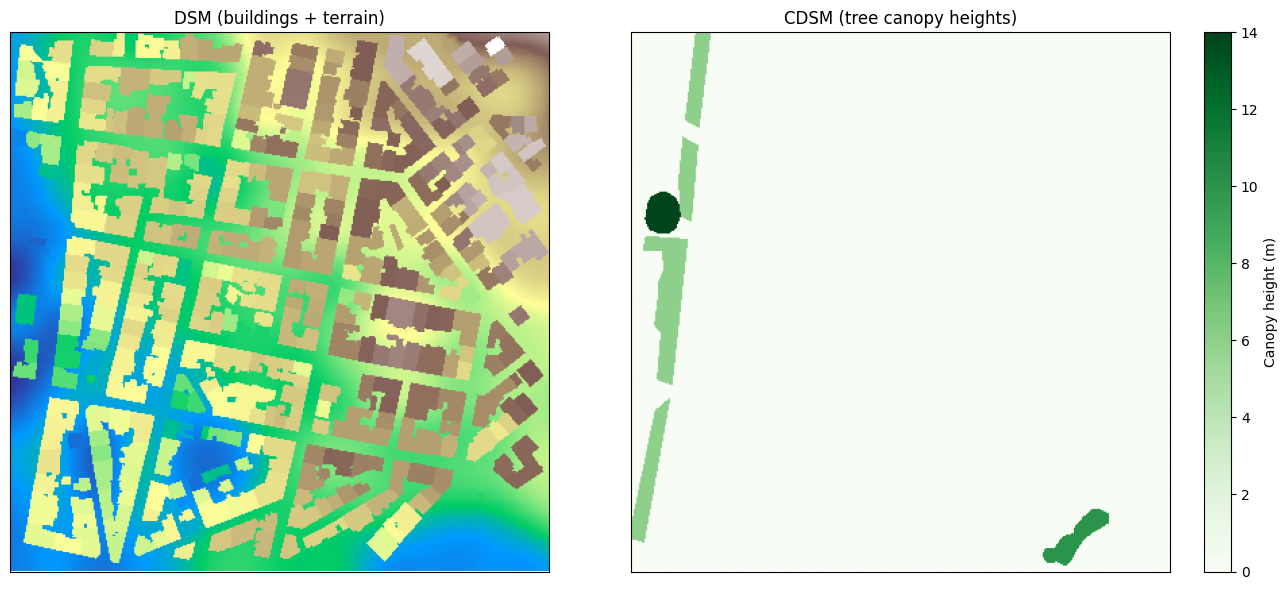

In [3]:
trees_gdf = gpd.read_file(str(DATA_DIR / "trees.gpkg"))
trees_gdf = trees_gdf.to_crs(TARGET_CRS)

print(f"Tree polygons: {len(trees_gdf)}")
print(f"Height range: {trees_gdf['height'].min():.1f} – {trees_gdf['height'].max():.1f} m")

cdsm_rast, cdsm_transf = solweig.io.rasterise_gdf(
    trees_gdf,
    "geometry",
    "height",
    bbox=EXTENTS_BBOX,
    pixel_size=1.0,
)

# Save so SurfaceData.prepare() can load it
cdsm_path = WORK_DIR / "CDSM.tif"
solweig.io.save_raster(
    str(cdsm_path),
    cdsm_rast,
    cdsm_transf.to_gdal(),
    CRS.from_epsg(TARGET_CRS).to_wkt(),
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(dsm, cmap="terrain")
axes[0].set_title("DSM (buildings + terrain)")
im1 = axes[1].imshow(cdsm_rast, cmap="Greens", vmin=0)
axes[1].set_title("CDSM (tree canopy heights)")
plt.colorbar(im1, ax=axes[1], label="Canopy height (m)")
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## 3. Prepare the surface

`SurfaceData.prepare()` loads the DSM and CDSM, computes wall heights and aspects,
calculates Sky View Factors (SVF), and caches everything in `working_dir` for reuse.


In [4]:
surface = solweig.SurfaceData.prepare(
    dsm=str(DATA_DIR / "DSM.tif"),
    working_dir=str(WORK_DIR / "working"),
    cdsm=str(cdsm_path),
    bbox=EXTENTS_BBOX,
    pixel_size=1.0,
)

print(f"Surface shape: {surface.dsm.shape}")
print(f"Pixel size: {surface.pixel_size} m")

INFO:solweig.models.surface:Preparing surface data from GeoTIFF files...
INFO:solweig.io:No-data value is -9999.0, replacing with NaN


INFO:solweig.models.surface:  DSM: 400×400 pixels
INFO:solweig.models.surface:  Using specified pixel size: 1.00 m
INFO:solweig.models.surface:  CRS validated: GGRS87 / Greek Grid (EPSG:2100)
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.models.surface:  ✓ Canopy DSM (CDSM) provided
INFO:solweig.models.surface:  → No TDSM provided - will auto-generate from CDSM (ratio=0.25)
INFO:solweig.models.surface:Checking for preprocessing data...
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.models.surface:  ✓ Walls found in working_dir: temp/tutorial_cache/working/walls/px1.000
INFO:solweig.models.surface:  ✓ SVF loaded from memmap (memory-efficient)
INFO:solweig.models.surface:  ✓ SVF found in working_dir: temp/tutorial_cache/working/svf/px1.000
INFO:solweig.models.surface:  ✓ Shadow matrices loaded from npz
INFO:solweig.models.surface:  ✓ Shadow matrices found (anisotropic sky e

Surface shape: (400, 400)
Pixel size: 1.0 m


## 4. Load weather data

We load a single afternoon timestep from the Athens EPW file — July 1st at 14:00,
a hot summer hour with strong solar radiation.


In [5]:
epw_path = str(DATA_DIR / "athens_2023.epw")
weather_list = solweig.Weather.from_epw(epw_path, start="2023-07-01", end="2023-07-01")
location = solweig.Location.from_epw(epw_path)

# Pick the 14:00 timestep
weather_14h = [w for w in weather_list if w.datetime.hour == 14][0]

print(f"Location: {location.latitude:.2f}°N, {location.longitude:.2f}°E")
print(f"Datetime: {weather_14h.datetime}")
print(f"Air temperature: {weather_14h.ta:.1f}°C")
print(f"Relative humidity: {weather_14h.rh:.0f}%")
print(f"Global radiation: {weather_14h.global_rad:.0f} W/m²")
print(f"Wind speed: {weather_14h.ws:.1f} m/s")

INFO:solweig.io:Loaded EPW file: NA, 8760 timesteps (pure Python parser)
INFO:solweig.models.weather:Loaded 24 timesteps from EPW: 2023-07-01 00:00 → 2023-07-01 23:00
INFO:solweig.models.weather:Location from EPW: NA — 38.0000°N, 23.7500°E (UTC+2, 175m)


Location: 38.00°N, 23.75°E
Datetime: 2023-07-01 14:00:00
Air temperature: 30.3°C
Relative humidity: 43%
Global radiation: 889 W/m²
Wind speed: 3.3 m/s


## 5. Calculate Tmrt

We run a single-timestep calculation using `calculate()` and save the outputs to disk.


INFO:solweig.tiling:Resource-aware tile sizing (context=solweig): GPU max_buffer=9,534,832,640 bytes, system RAM=17,179,869,184 bytes, max_tile_side=4634 px
[GPU] Shadow GPU context initialized successfully
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:Starting SOLWEIG timeseries calculation
INFO:solweig.timeseries:  Grid size: 400×400 pixels
INFO:solweig.timeseries:  Timesteps: 1
INFO:solweig.timeseries:  Period: 2023-07-01 14:00 → 2023-07-01 14:00
INFO:solweig.timeseries:  Location: 38.00°N, 23.75°E
INFO:solweig.timeseries:  Options: anisotropic sky
INFO:solweig.timeseries:  Auto-save: temp/tutorial_cache/output_quickstart (tmrt, shadow)
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:Pre-computing sun positions and radiation splits...
INFO:solweig.timeseries:  Pre-computed 1 timesteps in 0.1s
SOLWEIG timeseries:   0%|          | 0/1 [00:00<?, ?it/s][GPU] Alloca

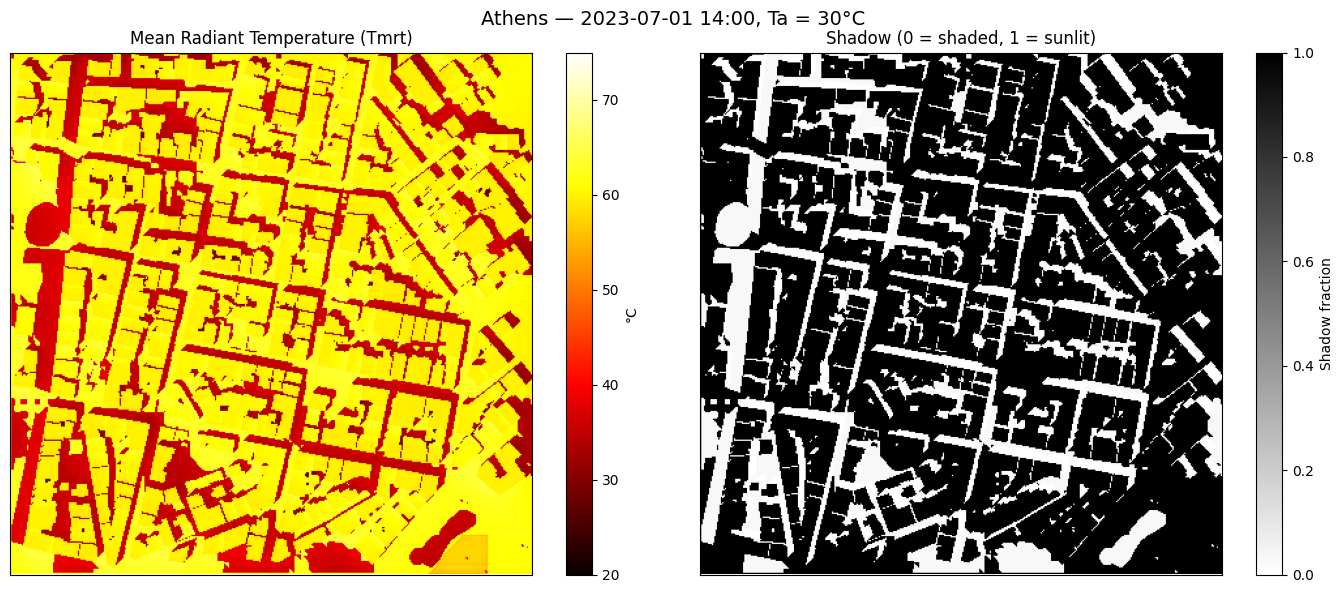

In [6]:
OUTPUT_DIR = WORK_DIR / "output_quickstart"

summary = solweig.calculate(
    surface=surface,
    weather=[weather_14h],
    location=location,
    output_dir=str(OUTPUT_DIR),
    outputs=["tmrt", "shadow"],
)

# Load per-timestep outputs from disk
tmrt, *_ = solweig.io.load_raster(str(OUTPUT_DIR / "tmrt" / "tmrt_20230701_1400.tif"))
shadow, *_ = solweig.io.load_raster(str(OUTPUT_DIR / "shadow" / "shadow_20230701_1400.tif"))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(tmrt, cmap="hot", vmin=20, vmax=75)
axes[0].set_title("Mean Radiant Temperature (Tmrt)")
plt.colorbar(im0, ax=axes[0], label="°C")

im1 = axes[1].imshow(shadow, cmap="gray_r", vmin=0, vmax=1)
axes[1].set_title("Shadow (0 = shaded, 1 = sunlit)")
plt.colorbar(im1, ax=axes[1], label="Shadow fraction")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(f"Athens — {weather_14h.datetime:%Y-%m-%d %H:%M}, Ta = {weather_14h.ta:.0f}°C", fontsize=14)
plt.tight_layout()
plt.show()

## 6. Sun vs. shade

One of the most useful insights from SOLWEIG is the Tmrt difference between sunlit and shaded areas.
This is the radiation benefit of shade — trees, buildings, or other structures.


In [7]:
sunlit_mask = shadow > 0.5
shaded_mask = shadow < 0.5

tmrt_sun = np.nanmean(tmrt[sunlit_mask])
tmrt_shade = np.nanmean(tmrt[shaded_mask])

print(f"Mean Tmrt (all):    {np.nanmean(tmrt):.1f}°C")
print(f"Mean Tmrt (sunlit): {tmrt_sun:.1f}°C")
print(f"Mean Tmrt (shaded): {tmrt_shade:.1f}°C")
print(f"Sun–shade difference: {tmrt_sun - tmrt_shade:.1f}°C")

Mean Tmrt (all):    53.7°C
Mean Tmrt (sunlit): 61.0°C
Mean Tmrt (shaded): 35.1°C
Sun–shade difference: 25.9°C
